# Cat and Dog Classification
Classify images of cats and dogs using Histogram of Oriented Gradients (HOG) for feature extraction and Decision Tree for classification. 

In [8]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [16]:
# Load dataset
data_dir = r'C:\Users\Kavosh\Desktop\techstack2025-ai\week4\task\dataset'
images, labels = [], []

for file in os.listdir(data_dir):
    if file.endswith('.jpg'):
        img_path = os.path.join(data_dir, file)
 
        if file.startswith('cat'):
            labels.append(0)  # Cat
        elif file.startswith('dog'):
            labels.append(1)  # Dog
        else:
            continue

        img = imread(img_path)
        img = rgb2gray(img)  # Convert to grayscale
        img_resized = resize(img, (128, 128), anti_aliasing=True)
        images.append(img_resized)

images = np.array(images)
labels = np.array(labels)
print('Images shape:', images.shape)
print('Labels shape:', labels.shape)
print(f'Number of cats: {np.sum(labels == 0)}')
print(f'Number of dogs: {np.sum(labels == 1)}')

Images shape: (615, 128, 128)
Labels shape: (615,)
Number of cats: 260
Number of dogs: 355


In [17]:
def extract_hog_features(images, visualize=False):
    """Extract HOG features from a list of grayscale images.
    
    Args:
        images: Array of grayscale images (N, 128, 128).
        visualize: If True, return HOG visualizations.
    
    Returns:
        hog_features: Array of HOG features (N, feature_size).
        hog_images: Array of HOG visualizations (N, 128, 128) if visualize=True, else None.
    """
    hog_features = []
    hog_images = [] if visualize else None

    for img in images:
        if visualize:
            features, hog_image = hog(
                img,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                visualize=True,
                block_norm='L2-Hys'
            )
            hog_features.append(features)
            hog_images.append(hog_image)
        else:
            features = hog(
                img,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                visualize=False,
                block_norm='L2-Hys'
            )
            hog_features.append(features)

    hog_features = np.array(hog_features)
    if visualize:
        hog_images = np.array(hog_images)
        return hog_features, hog_images
    return hog_features, None

In [26]:
def split_and_save_dataset(images, labels, test_size=0.2, train_dir='./dog-cat/train', test_dir='./dog-cat/test'):
    """Split dataset into training and test sets and save images to separate directories.
    
    Args:
        images: Array of grayscale images (N, 128, 128).
        labels: Array of labels (0 for cat, 1 for dog).
        test_size: Fraction of data for test set.
        train_dir: Directory to save training images.
        test_dir: Directory to save test images.
    
    Returns:
        X_train, X_test: HOG features for training and test sets.
        y_train, y_test: Labels for training and test sets.
        idx_train, idx_test: Indices for training and test sets.
    """
    from skimage.io import imsave
    from skimage import img_as_ubyte

    # تقسیم داده‌ها با stratify برای حفظ تعادل کلاس‌ها
    idx = np.arange(len(images))
    idx_train, idx_test, y_train, y_test = train_test_split(
        idx, labels, test_size=test_size, stratify=labels, random_state=42
    )

    # استخراج ویژگی HOG برای مجموعه آموزش و تست
    hog_features, _ = extract_hog_features(images, visualize=False)
    X_train, X_test = hog_features[idx_train], hog_features[idx_test]

    # ساخت پوشه‌ها در صورت نبود
    for d in [train_dir, test_dir]:
        os.makedirs(os.path.join(d, "cat"), exist_ok=True)
        os.makedirs(os.path.join(d, "dog"), exist_ok=True)

    # ذخیره تصاویر آموزش
    for i in idx_train:
        cls = 'cat' if labels[i] == 0 else 'dog'
        img_uint8 = img_as_ubyte(images[i])  # تبدیل به uint8
        imsave(os.path.join(train_dir, cls, f'{cls}_{i}.jpg'), img_uint8)

    # ذخیره تصاویر تست
    for i in idx_test:
        cls = 'cat' if labels[i] == 0 else 'dog'
        img_uint8 = img_as_ubyte(images[i])  # تبدیل به uint8
        imsave(os.path.join(test_dir, cls, f'{cls}_{i}.jpg'), img_uint8)

    return X_train, X_test, y_train, y_test, idx_train, idx_test


In [19]:
def train_decision_tree(X_train, y_train):
    """Train a Decision Tree classifier on HOG features.
    
    Args:
        X_train: HOG features for training (N_train, feature_size).
        y_train: Training labels (0 for cat, 1 for dog).
    
    Returns:
        clf: Trained Decision Tree classifier.
    """
    clf = DecisionTreeClassifier(random_state=42, max_depth=20)
    clf.fit(X_train, y_train)
    return clf


In [20]:
def evaluate_model(clf, X_test, y_test):
    """Evaluate the Decision Tree classifier on the test set.
    
    Args:
        clf: Trained Decision Tree classifier.
        X_test: HOG features for test set (N_test, feature_size).
        y_test: Test labels (0 for cat, 1 for dog).
    
    Returns:
        accuracy: Test set accuracy.
        y_pred: Predicted labels for test set.
    """
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, y_pred


Test Accuracy: 0.8618


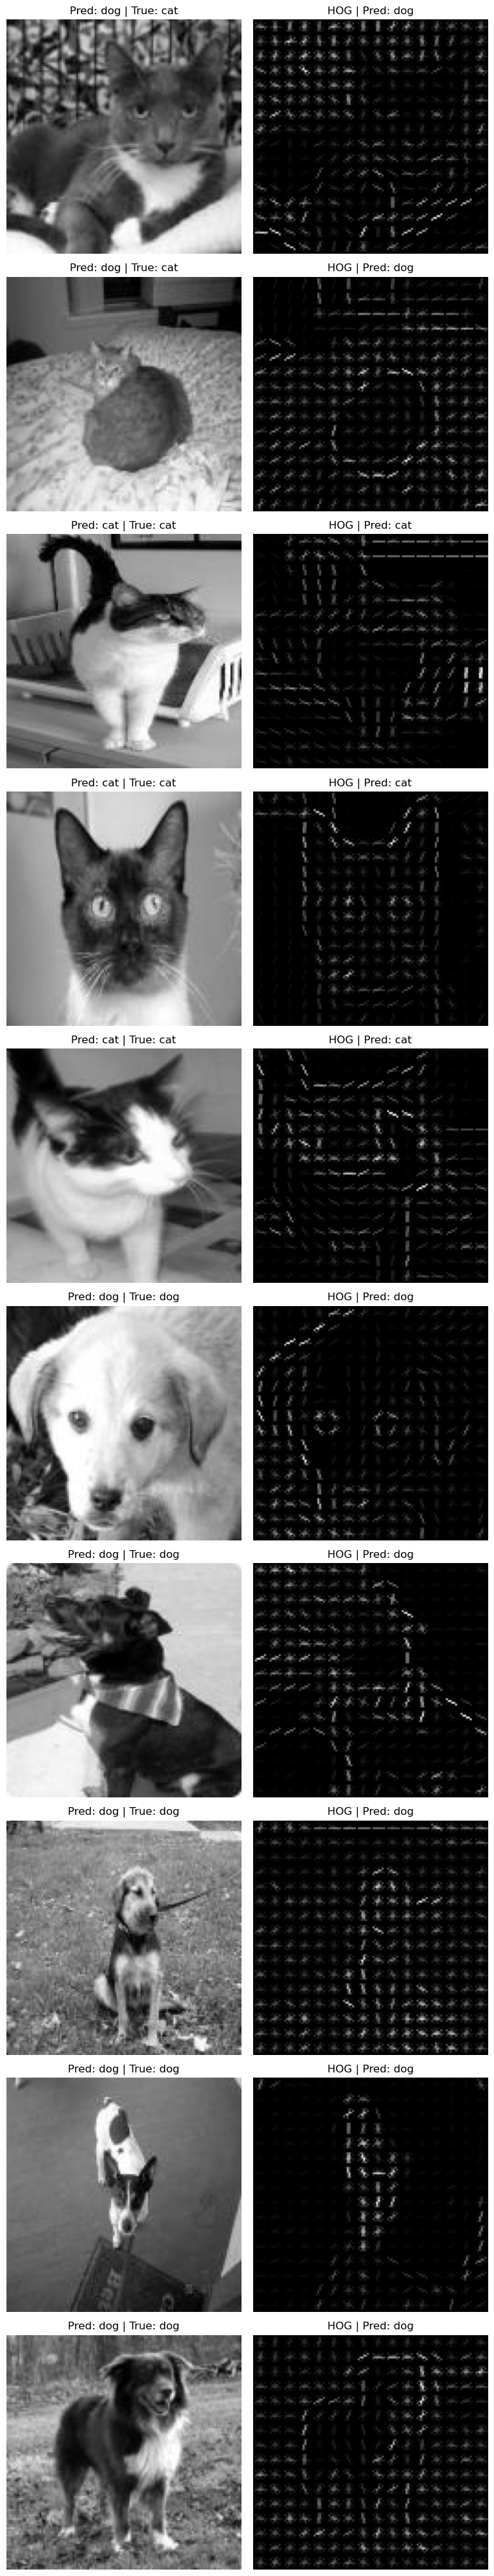

In [23]:
# Extract HOG features
hog_features, hog_images = extract_hog_features(images, visualize=True)

# Split and save dataset
X_train, X_test, y_train, y_test, idx_train, idx_test = split_and_save_dataset(images, labels, test_size=0.2)

# Train Decision Tree
clf = train_decision_tree(X_train, y_train)

# Evaluate model
accuracy, y_pred = evaluate_model(clf, X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Visualize results
classes = ['cat', 'dog']
cat_indices = [idx for idx in idx_test if y_test[np.where(idx_test == idx)[0][0]] == 0]
dog_indices = [idx for idx in idx_test if y_test[np.where(idx_test == idx)[0][0]] == 1]
sample_indices = cat_indices[:min(5, len(cat_indices))] + dog_indices[:min(5, len(dog_indices))]

fig, axes = plt.subplots(len(sample_indices), 2, figsize=(8, 4 * len(sample_indices)))
for i, idx in enumerate(sample_indices):
    ax = axes[i, 0] if len(sample_indices) > 1 else axes[0]
    true_label = y_test[np.where(idx_test == idx)[0][0]]
    pred_label = y_pred[np.where(idx_test == idx)[0][0]]
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(f'Pred: {classes[pred_label]} | True: {classes[true_label]}')
    ax.axis('off')

    ax = axes[i, 1] if len(sample_indices) > 1 else axes[1]
    ax.imshow(hog_images[idx], cmap='gray')
    ax.set_title(f'HOG | Pred: {classes[pred_label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()